In [1]:
using LinearAlgebra
using Plots
using BenchmarkTools
using ProgressMeter

In [2]:
include("Operators.jl")

laplacian! (generic function with 1 method)

In [3]:
global const ESCAPE_AXIS= 2;

In [4]:
# Research about the appropriate grid size for inhomogeneous media

# Appropriate values
zgrid= 1:1:100; # m
ygrid= 1:1; # m
xgrid= 1:1:200; # m
dx, dy, dz= step.([xgrid, ygrid, zgrid])

nz, ny, nx= length.([zgrid, ygrid, xgrid]);

In [5]:
# Constants
μ= μ0= 4π* 1e-7; # H/m x 1e3
ϵ= ϵ0= 8.85e-12; # F/m x 1e-3
σ= 0.1 .*ones(Float32, nz, ny, nx); # Ωm # we can include anisotropy too!!
# σ[:,:,10:20].= 1.;
σ[10:20, :, 1:end].= 1.;
ρ= 1 ./σ;

In [6]:
# Change tgrid according to dx for inhomogenous media
dt= 5e-9; #dx.*minimum(ϵ.*σ.*μ) .* 0.1;
tgrid= 0:dt:5e-6; #e-14;
nt= length(tgrid);

In [7]:
"""
Update E for one time step
"""
dσ= zeros(Float32, nz,ny,nx);
d2E= zeros(Float32, nx,ny,nz);
dE= zeros(Float32, nx,ny,nz);

function update_E!(E, d2E, d2E_temp, dE, ρ, dρ, dJs, dMs, nt, Δx, Δy, Δz, Δt)
    
    dfn= [d_x!, d_y!, d_z!];
    d2fn= [d2_x!, d2_y!, d2_z!];
    Δs= [Δx, Δy, Δz];
    
    for i in 1:3 # components
        
        laplacian!(d2E, d2E_temp, E[:,:,:,nt-1,i], Δx, Δy, Δz);
        dfn[i](dρ, ρ, Δs[i]);
        E[:,:,:,nt,i].= E[:,:,:,nt-1,i].+ Δt.*ρ./μ.*(d2E.- dMs[:,:,:,nt-1,i]);        
        
    end 
    
end

update_E! (generic function with 1 method)

In [8]:
function update_H!(H, E, dE3, dE_p, dE_m, dMs, nt, Δx, Δy, Δz, Δt)
    curl!(dE3, dE_p, dE_m, view(E, :,:,:,nt-1,:), Δx, Δy, Δz)
    H[:,:,:,nt,:].= H[:,:,:,nt-1,:].-1/μ.*Δt.*(dE3).+ Δt.*dMs[:,:,:,nt-1,:];
end

update_H! (generic function with 1 method)

In [9]:
E= zeros(Float32, nz, ny, nx, nt, 3);
H= zeros(Float32, nz, ny, nx, nt, 3);

d2E= zeros(Float32, nz, ny, nx);
dE= zeros(Float32, nz, ny, nx);
dE3= zeros(Float32, nz, ny, nx, 3);
dE_p= zeros(Float32, nz, ny, nx);
dE_m= zeros(Float32, nz, ny, nx);
d2E_temp= zeros(Float32, nz, ny, nx);


dρ= zeros(nz, ny, nx);

In [10]:
# Js is an electric field source. Letting this to zero for the moment.
Js= zeros(nz, ny, nx, nt, 3)
Js[(Int(round(nx/2))),1,(Int(round(nz/2))),:,3].= 0 .*sin.(5 .*(1:nt)./nt *2π);
dJs= zeros(nz, ny, nx, nt, 3)
djs= zeros(1,nt);
diff!(djs, Js[(Int(round(nx/2))),:,(Int(round(nz/2))),:,3], 2, [:,1], [:,1], [:,1], dt)
# dJs[(Int(round(nx/2))),:,(Int(round(nz/2))),:,3].= djs;

In [11]:
# Ms is the magnetic field source.
Ms= zeros(nz, ny, nx, nt, 3)
dMs= zeros(nz, ny, nx, nt, 3)
dMs_p= zeros(nz, ny, nx)
dMs_m= zeros(nz, ny, nx);

In [12]:
# A dipole source at z= 0
Ms[1,1,Int(round(2nx/6)):Int(round(4nx/6)),1,2].= (nx/6:-1:-nx/6).^3;# .*sin.(2π*f.* tgrid);# (500 .*(1:nt)./nt *2π);

for it in 1:nt
    curl!(view(dMs,:,:,:,it,:), dMs_p, dMs_m, Ms[:,:,:,it,:], dx, dy, dz);
end

In [14]:
@showprogress for it in 2:nt
    update_E!(E, d2E, d2E_temp, dE, ρ, dρ, dJs, dMs, it, dx, dy, dz, dt);
    update_H!(H, E, dE3, dE_p, dE_m, dMs, it, dx, dy, dz, dt);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [15]:
lim= extrema(H)
anim= @animate for it in 1:20:nt
    p1= heatmap(xgrid, zgrid, H[:,1,:,it,1], yflip= true, title= "$it", clim= lim)
    p2= heatmap(xgrid, zgrid, H[:,1,:,it,2], yflip= true, title= "$it", clim= lim)
    p3= heatmap(xgrid, zgrid, H[:,1,:,it,3], yflip= true, title= "$it", clim= lim./100)
    plot(p1,p2,p3, layout= (1,3), size= (1000, 300), ylim= (0,40))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_XTMG9J", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/magnetic_field.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/magnetic_field.gif")
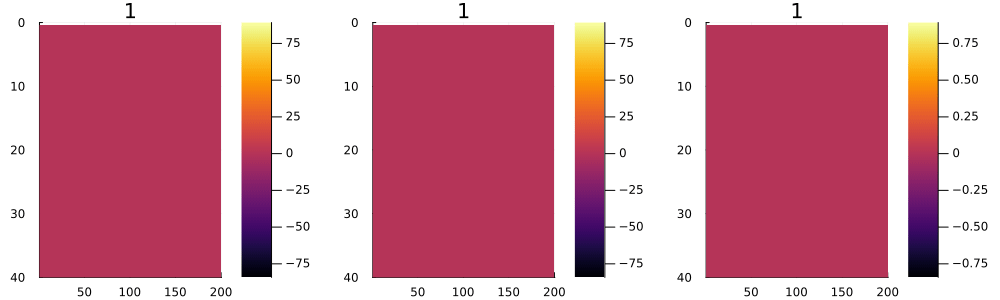

In [16]:
gif(anim, "magnetic_field.gif")

In [17]:
lim= extrema(E)./10
anim= @animate for it in 1:20:nt
    p1= heatmap(xgrid, zgrid, E[:,1,:,it,1], yflip= true, title= "$it", clim= lim)
    p2= heatmap(xgrid, zgrid, E[:,1,:,it,2], yflip= true, title= "$it", clim= lim)
    p3= heatmap(xgrid, zgrid, E[:,1,:,it,3], yflip= true, title= "$it", clim= lim)
    plot(p1,p2,p3, layout= (1,3), 
        size= (1000, 300))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_tsp3ci", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/electric_field.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/electric_field.gif")
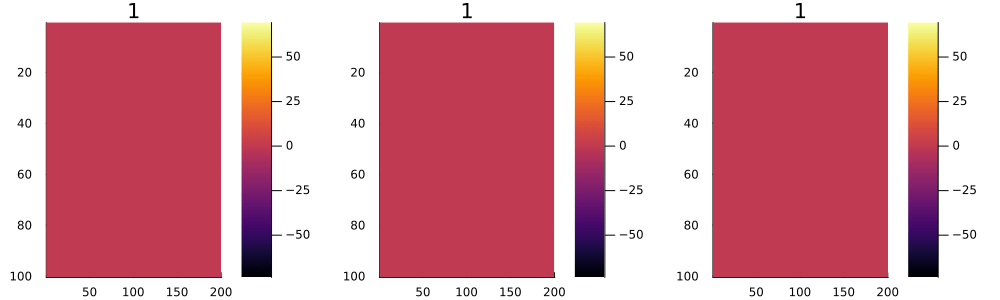

In [18]:
gif(anim, "electric_field.gif")

In [19]:
lim= extrema(σ.*E)./10
anim= @animate for it in 1:20:nt
    p1= heatmap(xgrid, zgrid, σ[:,1,:].*E[:,1,:,it,1], yflip= true, title= "$it", clim= lim)
    p2= heatmap(xgrid, zgrid, σ[:,1,:].*E[:,1,:,it,2], yflip= true, title= "$it", clim= lim)
    p3= heatmap(xgrid, zgrid, σ[:,1,:].*E[:,1,:,it,3], yflip= true, title= "$it", clim= lim)
    plot(p1,p2,p3, layout= (1,3), 
        size= (1000, 300))
end

Animation("/var/folders/x1/3hy4wtvs4b33gn48_tg_n29w0311lh/T/jl_edw6ID", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to /Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/current density.gif
└ @ Plots /Users/asingh933/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/asingh933/Desktop/wassup_danger/wave_simulation/Finite difference/current density.gif")
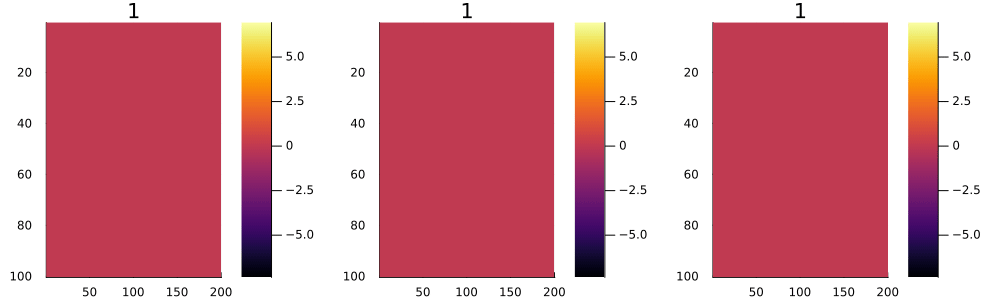

In [20]:
gif(anim, "current density.gif")

A dipole field is incident on the surface, using `Ms`. This field is parallel to the y-direction, which is why we see the magnetic field only in the y-component. This should induce electric fields in both x and z-direction but we do not see anything in the x-component because in our 2D scenario we have assumed that the field is invariant in the y-direction. This is also called the Transverse Magnetic mode. </br>
Once the electric fields are generated they diffuse out according the conductivity of the medium.